In [1]:
from pennylane import numpy as np
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [2]:
dev = qml.device('default.qubit', wires=8)

In [3]:

PATH_Model2 = '/home/tak/Github/QEmbedding/Other Experiments/Scalability/8 qubits/PCA-NQE500.pt'
PATH_Model3 = '/home/tak/Github/QEmbedding/Other Experiments/Scalability/8 qubits/NQE500.pt'

In [4]:
class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(8, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 16)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 16, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

model2.load_state_dict(torch.load(PATH_Model2))
model3.load_state_dict(torch.load(PATH_Model3))

<All keys matched successfully>

In [10]:
@qml.qnode(dev)
def overlap_circuit1(x1,x2):
    embedding.QuantumEmbedding1(x1)
    embedding.QuantumEmbedding1_inverse(x2)
    return qml.probs(wires=range(8))

@qml.qnode(dev)
def overlap_circuit2(x1,x2):
    embedding.QuantumEmbedding2(x1)
    embedding.QuantumEmbedding2_inverse(x2)
    return qml.probs(wires=range(8))

def kernel(x1, x2, NQE):
    if NQE == False:
        kernel = overlap_circuit1(x1,x2)
    
    
    elif NQE == 'PCA-NQE':
        x1 = model2(torch.tensor(x1))
        x2 = model2(torch.tensor(x2))
        kernel = overlap_circuit2(x1, x2)

    elif NQE == 'NQE':
        x1 = model3(torch.tensor(x1))[0]
        x2 = model3(torch.tensor(x2))[0]
        kernel = overlap_circuit2(x1,x2)
    
    return kernel

  

In [6]:
def get_error_bound(weights, Kernel):
    error_list = []
    for weight in weights:
        Kernel_MP = np.linalg.pinv(Kernel + weight * np.eye(N), hermitian = True)
        error_list.append(np.sqrt(Y_train @ Kernel_MP @ Kernel @ Kernel_MP @ Y_train.T / N))
        
    error_list = np.array(error_list)

    return error_list

QKM without NQE

In [33]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel0 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], False)
        Kernel0[i][j] = x[0]
        Kernel0[j][i] = x[0]

In [34]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel0)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list {k}\n")
f.write(str(error_list))
f.close()

QKM with PCA-NQE

In [35]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel2 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "PCA-NQE")
        Kernel2[i][j] = x[0]
        Kernel2[j][i] = x[0]

In [36]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel2)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list (PCA-NQE) {k}\n")
f.write(str(error_list))
f.close()

QKM with NQE

In [37]:
classes = [0,1]
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0,3,1,2).detach().numpy(), X_test.permute(0,3,1,2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel3 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "NQE")
        Kernel3[i][j] = x[0]
        Kernel3[j][i] = x[0]

In [38]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel3)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list (NQE) {k}\n")
f.write(str(error_list))
f.close()

In [40]:
weights = np.arange(0.1, 1, 0.1)
error_list0 = [0.77049043, 0.70521849, 0.65344111, 0.61070538, 0.57452783, 0.54333579,
 0.51605926, 0.49193417, 0.47039505, 0.79012626, 0.72189154, 0.66737544, 0.62233916, 0.58426451, 0.55150982,
 0.52294078, 0.49774025, 0.47530056, 0.77403394, 0.70878274, 0.65686357, 0.6139686 , 0.57764699, 0.54633057,
 0.51894665, 0.49472728, 0.47310353, 0.80402648, 0.73256213, 0.67604657, 0.6296058 , 0.59046619, 0.5568611,
 0.52758745, 0.50178713, 0.47882646, 0.80382001, 0.73454565, 0.67922668, 0.63345735, 0.59468118, 0.56124957,
 0.53202895, 0.50620421, 0.48316925]
error_list2 = [0.18344815, 0.13303771, 0.11040356, 0.09689642, 0.08780517, 0.08125579,
 0.07632202, 0.0724837 , 0.06942305, 0.2200323 , 0.1444985 , 0.11355807, 0.09655904, 0.08584985, 0.07853253,
 0.0732528 , 0.06928975, 0.06622381, 0.26502706, 0.18348403, 0.14775463, 0.12686591, 0.11293472, 0.1029105,
 0.09533035, 0.08939295, 0.08461777, 0.23012171, 0.15803408, 0.12715585, 0.10949233, 0.09792694, 0.08972807,
 0.08360267, 0.07885265, 0.07506506, 0.23100261, 0.16451064, 0.13389942, 0.11539357, 0.10283736, 0.09374047,
 0.08685854, 0.08148737, 0.07719415]
error_list3 = [0.17217461, 0.13278258, 0.11476556, 0.10391002, 0.09646766, 0.0909641,
 0.08668775, 0.0832476 , 0.08040832, 0.17736586, 0.13544583, 0.11729941, 0.10665277, 0.09942534, 0.09408397,
 0.08991525, 0.08653791, 0.08372712, 0.15532117, 0.12128336, 0.10601548, 0.09696474, 0.09082227, 0.08630414,
 0.08280024, 0.07998018, 0.07764772, 0.17358991, 0.1353191 , 0.11797469, 0.10741266, 0.10007388, 0.09458126,
 0.09027081, 0.08677527, 0.08387152, 0.17753348, 0.1341725 , 0.11563997, 0.1048927 , 0.09766222, 0.09235581,
 0.08823794, 0.08491801, 0.08216685]

error_list0, error_list2, error_list3 = np.array(error_list0), np.array(error_list2), np.array(error_list3)
error_list0 = error_list0.reshape(5,9)
error_list2 = error_list2.reshape(5,9)
error_list3 = error_list3.reshape(5,9)

error_list0_mean, error_list0_std = error_list0.mean(axis=0), error_list0.std(axis=0)
error_list2_mean, error_list2_std = error_list2.mean(axis=0), error_list2.std(axis=0)
error_list3_mean, error_list3_std = error_list3.mean(axis=0), error_list3.std(axis=0)

/tmp/ipykernel_12633/1315228976.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
/tmp/ipykernel_12633/1315228976.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
/tmp/ipykernel_12633/1315228976.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA s

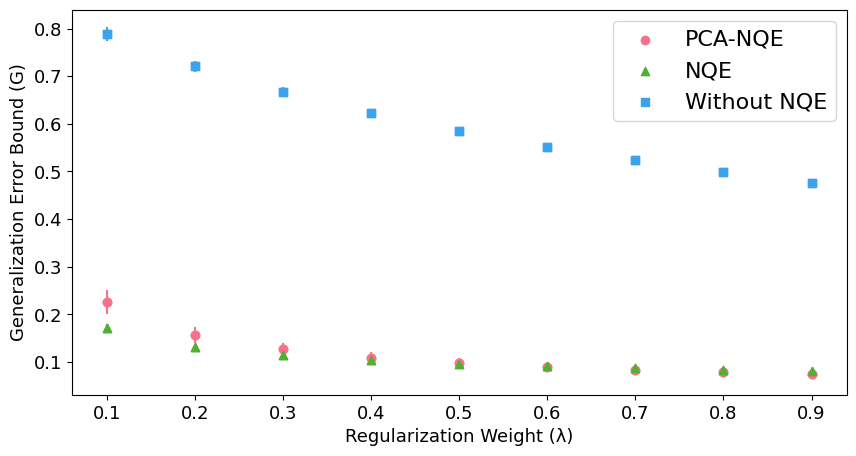

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    
    ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
    ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
    ax.scatter(weights, error_list0_mean, label="Without NQE", marker="s", c=clrs[2])
    
    
    ax.errorbar(weights, error_list2_mean, yerr=error_list2_std, fmt="o", c=clrs[0])
    ax.errorbar(weights, error_list3_mean, yerr=error_list3_std, fmt="^", c=clrs[1])
    ax.errorbar(weights, error_list0_mean, yerr=error_list0_std, fmt="s", c=clrs[2])

ax.set_xlabel("Regularization Weight (λ)")
ax.set_ylabel("Generalization Error Bound (G)")
#ax.set_title("Generalization Error Bounds against Regularization Weights")
ax.legend(fontsize=16)
plt.savefig("QKM Generalization.pdf")